## Connect To Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = "drive/MyDrive/CMP/"

Mounted at /content/drive


## Local

In [ ]:
# root = './'

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model
from sklearn import metrics

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Data Preparation

#### Load SUBTLEX data

In [ ]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root+'Datasets/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [ ]:
SUBTLEX_df['zipf'].describe()

count    74286.000000
mean         2.479172
std          0.835829
min          1.592864
25%          1.768955
50%          2.291834
75%          2.954592
max          7.621174
Name: zipf, dtype: float64

In [ ]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

#### Load ELP data and Merge with Subtlex data

Reading **words** and **non-words** FastText represention

In [ ]:
with open(root+'Datasets/FastText_V3/words_2M.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/FastText_V3/nonwords_2M.pkl', 'rb') as f:
  nonwords = pickle.load(f)

Adding appropriate encodings for extra information for both words and non-words

In [ ]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

Loading elp data and merging them with subtlex data

In [ ]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [ ]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
17335,Ipe's,0,"[-0.008398541, -0.005443717, 0.01434593, 0.000...","[0, 1]",0,0.000000,NW
36309,toothcamb,0,"[0.008599287, 0.006343102, 0.08993241, 0.03874...","[0, 1]",0,0.000000,NW
13860,flicks,702,"[0.034721207, -0.029017892, 0.042743854, -0.00...","[1, 0]",1,2.935287,LF
30576,Samoar,0,"[-0.019440493, -0.044849873, 0.055061113, 0.00...","[0, 1]",0,0.000000,NW
12956,lastened,0,"[-0.00028915014, -0.10609062, 0.019582193, 0.0...","[0, 1]",0,0.000000,NW


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elp_df['represention'],elp_df['code'], stratify=elp_df['label'], test_size=.2)

## Nueral Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 300)               90300     
                                                                 
 dense2 (Dense)              (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense3 (Dense)              (None, 100)               30100     
                                                                 
 dense4 (Dense)              (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense5 (Dense)              (None, 10)                5

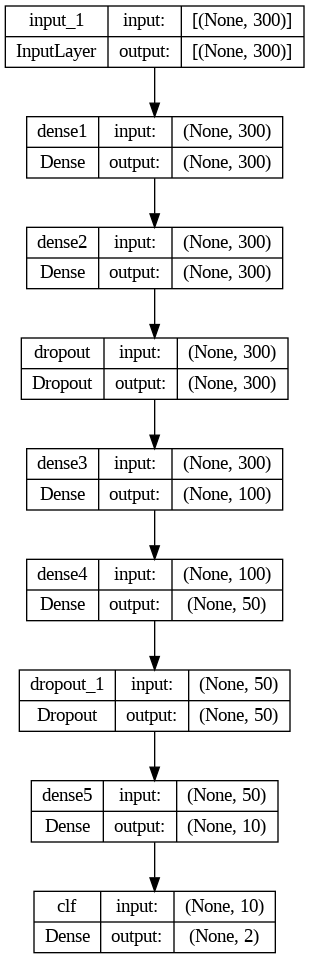

In [ ]:
# Sequential Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(300,)))
model.add(layers.Dense(300, activation="relu", name="dense1"))
model.add(layers.Dense(300, activation="relu", name="dense2"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(100, activation="relu", name="dense3"))
model.add(layers.Dense(50, activation="relu", name="dense4"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation="relu", name="dense5"))
model.add(layers.Dense(2, activation='softmax', name='clf'))

opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file=root+'/Plots/Classification/fully_connected_model.png', show_shapes=True)

In [ ]:
model.fit(
    x=np.array(list(X_train)),
    y=np.array(list(y_train)),
    validation_data=(np.array(list(X_test)), np.array(list(y_test))),
    epochs=10,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )
  ]
)

Epoch 1/10
1858/1858 [==============================] - 19s 9ms/step - loss: 0.0452 - accuracy: 0.9871 - val_loss: 0.0364 - val_accuracy: 0.9909
Epoch 2/10
1858/1858 [==============================] - 15s 8ms/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 0.0270 - val_accuracy: 0.9923
Epoch 3/10
1858/1858 [==============================] - 19s 10ms/step - loss: 0.0152 - accuracy: 0.9958 - val_loss: 0.0297 - val_accuracy: 0.9919
Epoch 4/10
1858/1858 [==============================] - 15s 8ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0334 - val_accuracy: 0.9924
Epoch 5/10
1858/1858 [==============================] - 15s 8ms/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.0528 - val_accuracy: 0.9925
Epoch 6/10
1858/1858 [==============================] - 17s 9ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0406 - val_accuracy: 0.9933
Epoch 7/10
1858/1858 [==============================] - 15s 8ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0506 - val_a

In [ ]:
model.save(root + '/check_points/fully_connected/FT_Model')

## Predicted Probabilities on full dataset


In [ ]:
full_dataset_predictions = model.predict(np.array(list(elp_df['represention'])))

2323/2323 [==============================] - 7s 3ms/step


#### Classification results

In [ ]:
print(metrics.classification_report(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9937    0.9962    0.9950     33978
           1     0.9968    0.9947    0.9957     40339

    accuracy                         0.9954     74317
   macro avg     0.9953    0.9954    0.9954     74317
weighted avg     0.9954    0.9954    0.9954     74317



In [ ]:
acc_score = (metrics.accuracy_score(np.argmax(np.array(list(elp_df['code'])), axis=1),  np.argmax(full_dataset_predictions, axis=1)))
acc_score

0.9953846360859561

#### Confusion Matrix

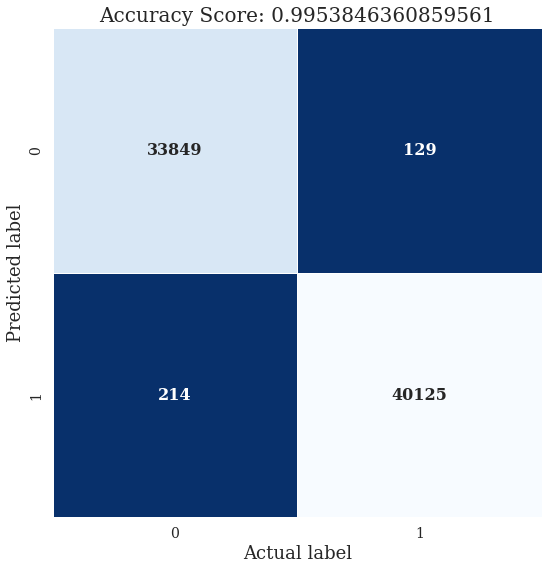

In [ ]:
cm = metrics.confusion_matrix(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig(root+'Plots/Classification/FC_full.pdf')

## Predicted Probabilities on Test dataset


In [ ]:
valid_dataset_predictions = model.predict(np.array(list(X_test)))

465/465 [==============================] - 1s 2ms/step


In [ ]:
print(metrics.classification_report(np.argmax(np.array(list(y_test)), axis=1), np.argmax(valid_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.9900    0.9932    0.9916      6796
           1     0.9943    0.9916    0.9929      8068

    accuracy                         0.9923     14864
   macro avg     0.9922    0.9924    0.9923     14864
weighted avg     0.9923    0.9923    0.9923     14864



In [ ]:
acc_score = (metrics.accuracy_score(np.argmax(np.array(list(y_test)), axis=1), np.argmax(valid_dataset_predictions, axis=1)))
acc_score

0.9923304628632938

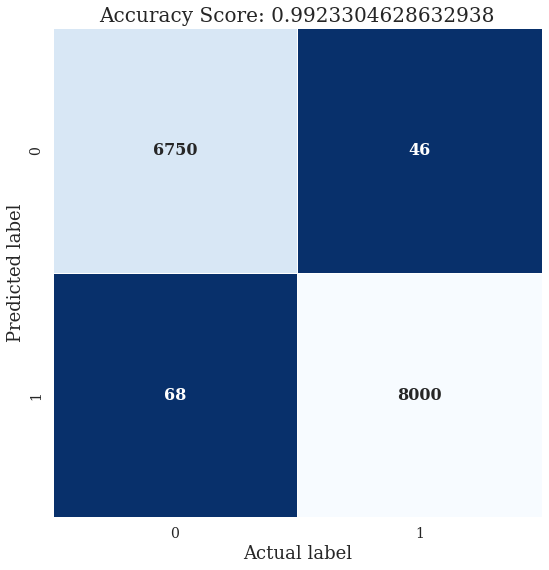

In [ ]:
cm_test = metrics.confusion_matrix(np.argmax(np.array(list(y_test)), axis=1), np.argmax(valid_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm_test, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig(root+'Plots/Classification/Test Res/FT_test_set.pdf')

# Pridected Probabilites for each words category and non-words on FULL DATSET

In [ ]:
elp_df['word_prob'] = full_dataset_predictions[:,0]
elp_df['nword_prob'] = full_dataset_predictions[:,1]

In [ ]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                          nword_prob  \
              mean       std  count       max           min       mean   
category                                                                 
HF        0.995132  0.041557  14333  1.000000  1.009140e-01   0.004868   
LF        0.991479  0.059594  19645  1.000000  1.517003e-05   0.008521   
NW        0.010372  0.067608  40339  0.999999  1.479611e-14   0.989628   

                                                   
               std  count       max           min  
category                                           
HF        0.041557  14333  0.899086  4.211127e-27  
LF        0.059594  19645  0.999985  6.709425e-14  
NW        0.067608  40339  1.000000  1.072958e-06

## Save Predicted Probabilities of full dataset


In [ ]:
elp_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [ ]:
elp_df_to_save

,string,freq,label,zipf,category,word_prob,nword_prob
17335,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
36309,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
13860,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
30576,Samoar,0,0,0.000000,NW,1.966544e-06,9.999980e-01
12956,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
35723,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
12736,exorcism,238,1,3.274105,HF,9.999999e-01,7.543647e-08
19204,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
37749,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [ ]:
elp_df_to_save.to_csv(root+"Datasets/fastText_FC.csv", header=0, index=False)